In [1]:
import os
import cv2
#import argparse

import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
#cambialo in base a dove lo hai messo tu
drive_folder = '/home/anto/University/Driving-Visual-Attention/data'

In [3]:
## COUNT FRAMES FUNCTION
def get_frame_count(input_video):
    '''
    func to count number of frames in input video
    '''
    count = 0
    vid = cv2.VideoCapture(input_video)
    while(True):
        ret, frame = vid.read()
        if(ret == False):
            break
        count += 1
    return count


## ALIGN VIDEO FUNCTION
def get_align_videos(drive_folder, driver, sample_no, driver_view_out, road_view_out, drop):
    '''
    func to obtain road view by matching frames from driver view,
    road view and projected road view to get the same number of frames in each.
    steps:
        -- get number of frames in driver view, projected road view and actual road view
        -- Drop extra frames using (drop = larger_frame_count/diff) to get equal number of frames in each video
    '''
    input_path = drive_folder + '/dataset_download'
    output_path = drive_folder + '/videos-aligned'
    driver_view = os.path.join(input_path, driver, 'driver_view', 'sample' +\
                                                                       str(sample_no) +'.avi')
    road_view = os.path.join(input_path, 'road_view', 'trip' + str(sample_no)\
                                                                     + '_out_hist.avi')
    if sample_no < 10:
        gt_point = os.path.join(input_path,'road_view', 'trip' + str(sample_no) + '_out.npy')
        gt_point = np.load(gt_point)
    else:
        gt_point = os.path.join(input_path,'road_view', 'trip' + str(sample_no) + '_out.txt')
        gt_point = pd.read_csv(gt_point, header = None).values

    cap_driver_view = cv2.VideoCapture(driver_view) # read driver view
    nframes_driver_view = get_frame_count(driver_view) # frame count of driver view video

    cap_road_view = cv2.VideoCapture(road_view) # read road view
    nframes_road_view = get_frame_count(road_view) # frame count of road view video

    fourcc = cv2.VideoWriter_fourcc(*'XVID')

    driver_view_out = os.path.join(output_path, driver, 'driver_view', 'sample' + str(sample_no) +'.avi')
    driver_view_out = cv2.VideoWriter(driver_view_out, fourcc, 25, (1440,1080))

    road_view_out = os.path.join(output_path, driver, 'road_view', 'sample' + str(sample_no) +'.avi')
    road_view_out = cv2.VideoWriter(road_view_out, fourcc, 25, (1920, 1080))

    road_gaze_point_out = os.path.join(output_path, driver, 'road_view', 'sample' + str(sample_no) +'.npy')

    i = 0; count = 0; k = 0; gaze_point_out = []

    nframes = nframes_driver_view

    while(i < nframes):
        i += 1
        if(drop != -1 and i%drop == 0):
            if(nframes_driver_view > nframes_road_view):
                ret1, frame1 = cap_driver_view.read()
            else:
                ret3, frame3 = cap_road_view.read()
                k +=1
        else:
            ret1, frame1 = cap_driver_view.read()
            ret3, frame3 = cap_road_view.read()
            if(ret1 == False or ret3 == False):
                break
            gaze_point_out.append(gt_point[k])
            k +=1
            count += 1
            driver_view_out.write(frame1)
            road_view_out.write(frame3)

    gaze_point_out = np.array(gaze_point_out)
    np.save(road_gaze_point_out, gaze_point_out)

    driver_view_out.release(); road_view_out.release();
    cap_driver_view.release(); cap_road_view.release()

## MAIN FUNCTION
def dataset(drive_folder):

    assert os.path.exists(drive_folder), "path does not exists!"

    drivers = os.listdir(drive_folder + '/dataset_download')

    for driver in drivers:
        if driver == 'road_view':
            continue;

        print(f'--> Processing for {driver}')

        nsamples = len(os.listdir(os.path.join(drive_folder,'dataset_download', driver, 'driver_view')))

        alligned_dataset_path = drive_folder + '/videos-aligned'
        driver_view_out = os.path.join(alligned_dataset_path, driver, 'driver_view')
        road_view_out = os.path.join(alligned_dataset_path, driver, 'road_view')

        if os.path.exists(driver_view_out) and os.path.exists(road_view_out):
            continue

        if not os.path.exists(driver_view_out):
            os.makedirs(driver_view_out, exist_ok=True)

        if not os.path.exists(road_view_out):
            os.makedirs(road_view_out, exist_ok=True)

        drop_data = pd.read_csv(os.path.join(drive_folder,'dataset_download', driver, 'drop_rate_per_video.csv'))
        samples = drop_data['sample_no']
        drop_rate = drop_data['drop_rate'].astype(int)

        for sample_no in tqdm(range(1, nsamples+1)):
            drop = drop_rate[np.where(samples == 'sample'+str(sample_no)+'.avi')[0][0]]
            get_align_videos(drive_folder, driver, sample_no, driver_view_out, road_view_out, drop)

In [4]:
dataset(drive_folder)

--> Processing for driver20
--> Processing for driver22
--> Processing for driver21
--> Processing for driver3
--> Processing for driver13
--> Processing for driver23
--> Processing for driver5
--> Processing for driver8


100%|██████████| 112/112 [06:08<00:00,  3.29s/it]


--> Processing for driver15


 57%|█████▋    | 64/112 [03:12<01:55,  2.41s/it]

In [ ]:
nn=get_frame_count('/content/drive/MyDrive/Uni_sapienza/EAI_Napoli/DGaze_dataset-alligned/driver10/road_view/sample20.avi')
print(nn)

38


In [ ]:
import os
import cv2
import argparse

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

def get_frame_count(input_video):
    '''
    func to count number of frames in input video
    '''
    count = 0
    vid = cv2.VideoCapture(input_video)
    while(True):
        ret, frame = vid.read()
        if(ret == False):
            break
        count += 1
    return count


def get_gaze_point(gt_point):
    '''
    func to return the center of the object bounding box
    '''
    bbox = gt_point
    pt1 = (bbox[:,3] + bbox[:,1])/2
    pt2 = (bbox[:,4] + bbox[:,2])/2
    pt1 = np.expand_dims(pt1, axis =1)
    pt2 = np.expand_dims(pt2, axis =1)
    gt_point = np.hstack((pt1.astype(int), pt2.astype(int)))
    return gt_point


def visualize_data(path, drivers, dataset_type, display_nsamples = 2):
    '''
    Visualize DGAZE dataset
    '''
    point_driver={}
    for driver in drivers:

        print(f'--> Processing for {driver}')

        nsamples = len(os.listdir(os.path.join(path, dataset_type, driver, 'driver_view')))
        nsamples_range = list(np.arange(1, nsamples+1))
        random.shuffle(nsamples_range)
        samples_list = nsamples_range[:display_nsamples]

        dic_sample={}
        for sample_no in tqdm(samples_list):
            driver_view = os.path.join(path, dataset_type, driver, 'driver_view', 'sample' + str(sample_no) +'.avi')
            road_view = os.path.join(path,  dataset_type, driver, 'road_view', 'sample' + str(sample_no) +'.avi')
            gaze_point_path = os.path.join(path,  dataset_type, driver, 'road_view', 'sample' + str(sample_no) +'.npy')
            gt_point = np.load(gaze_point_path, allow_pickle=True)

            if sample_no >= 10:
                gt_point = get_gaze_point(gt_point)

            cap_driver_view = cv2.VideoCapture(driver_view) # read driver view
            cap_road_view = cv2.VideoCapture(road_view) # read road view
            nframes = get_frame_count(driver_view) # frame count

            count = 0
            while(count < nframes):
                ret1, frame1 = cap_driver_view.read()
                ret2, frame2 = cap_road_view.read()
                if(ret1 == False or ret2 == False):
                    break
                count += 1
                if count == 20:
                    break

            frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
            frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)

            list_point=[]
            for j in range(gt_point.shape[0]):
                frame2 = cv2.circle(frame2, (gt_point[j][0], gt_point[j][1]), 1, (255, 0, 0), 50)
                list_point.append([gt_point[j][0], gt_point[j][1]])

            dic_sample[sample_no]=list_point

            frame = np.concatenate((frame1, frame2), axis = 1)
            plt.figure(figsize =(10,10))
            plt.imshow(frame)
            plt.show()

        point_driver[driver]=dic_sample

    return point_driver


--> Processing for driver13


  0%|          | 0/2 [00:00<?, ?it/s]

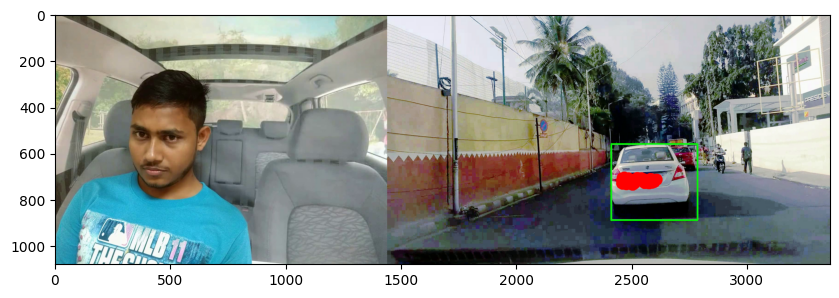

 50%|█████     | 1/2 [00:09<00:09,  9.03s/it]

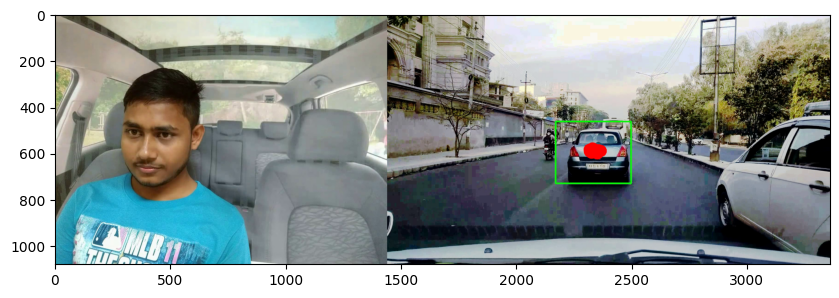

100%|██████████| 2/2 [00:13<00:00,  6.80s/it]


--> Processing for driver16


  0%|          | 0/2 [00:00<?, ?it/s]

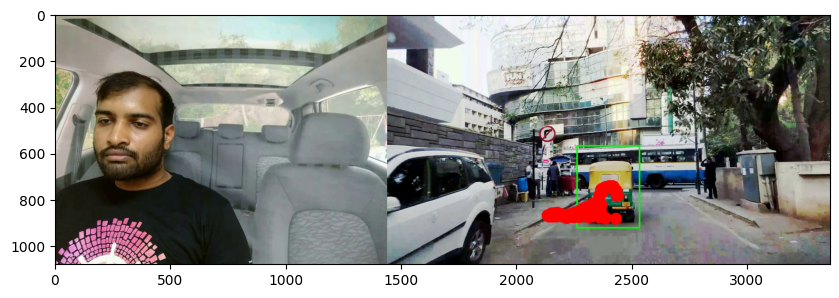

 50%|█████     | 1/2 [00:06<00:06,  6.74s/it]

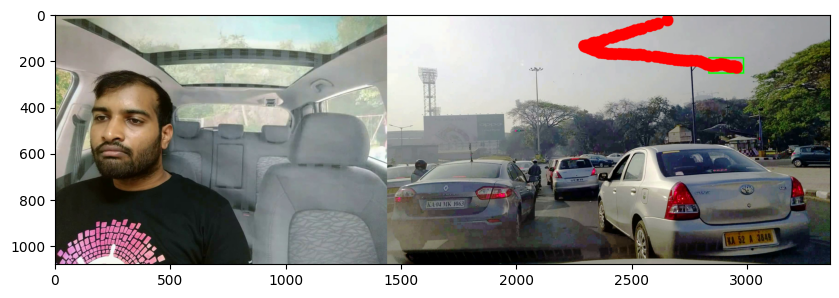

100%|██████████| 2/2 [00:11<00:00,  5.62s/it]


--> Processing for driver22


  0%|          | 0/2 [00:00<?, ?it/s]

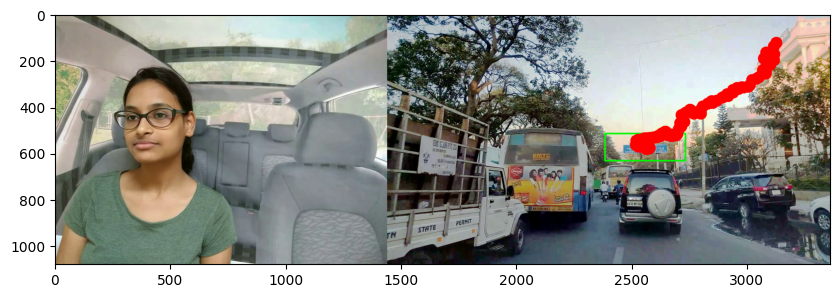

 50%|█████     | 1/2 [00:07<00:07,  7.69s/it]

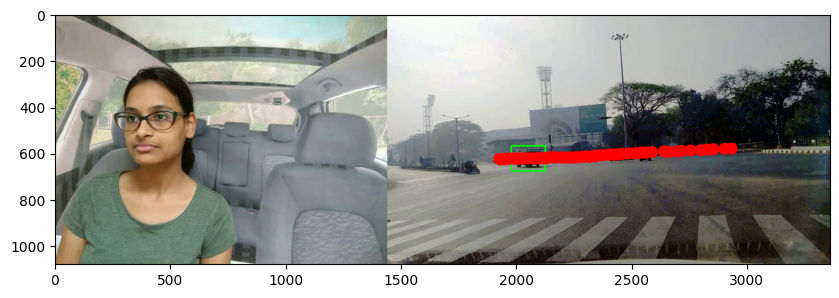

100%|██████████| 2/2 [00:11<00:00,  5.98s/it]


--> Processing for driver24


  0%|          | 0/2 [00:00<?, ?it/s]

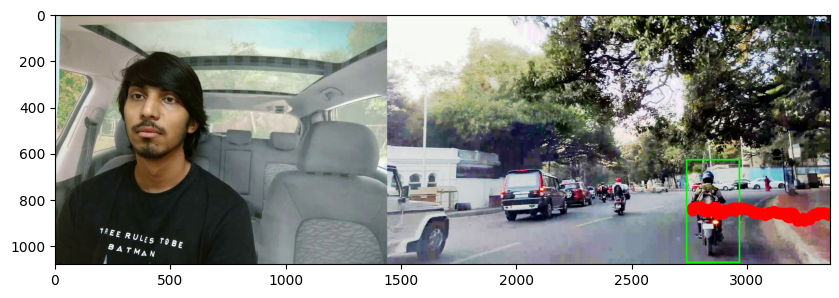

 50%|█████     | 1/2 [00:03<00:03,  3.57s/it]

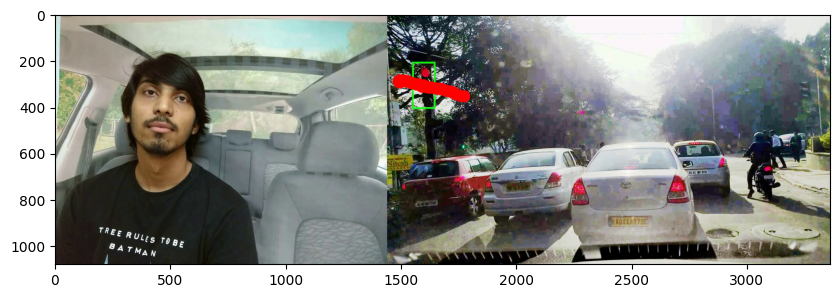

100%|██████████| 2/2 [00:06<00:00,  3.37s/it]


In [ ]:
path = '/content/drive/MyDrive/Uni_sapienza/EAI_Napoli'
display_ndrivers = 4
display_nsamples = 2

whichDataset='DGaze_dataset-alligned'
drivers = os.listdir(os.path.join(path, whichDataset))
random.shuffle(drivers)
res=visualize_data(path, drivers[:display_ndrivers], whichDataset, display_nsamples = display_nsamples)

In [ ]:
j=0
for i in res['driver24'][97]:
  print(f'frame{j} {i}')
  j+=1

In [ ]:
nn=np.load('/content/drive/MyDrive/Uni_sapienza/EAI_Napoli/DGaze_dataset-alligned/driver24/road_view/sample97.npy', allow_pickle=True)
print(nn)